In [1]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
import string

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
data_dir = '../input/flickr-image-dataset/flickr30k_images'
img_dir = os.path.join(data_dir, 'flickr30k_images')
images = list(os.listdir(img_dir))

data_file = os.path.join(data_dir, 'results.csv')


In [3]:
data = pd.read_csv(data_file, delimiter = '|')
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [4]:
data.columns = ['image_name','comment_number','comment']

In [5]:
print ("Number of images in image forlder = %d and number of entries in results.csv = %d" %(len(images), data.shape[0]))


Number of images in image forlder = 31785 and number of entries in results.csv = 158915


Notice that for one image there can be multiple labels in the comment section. For example, for image id 1000092795.jpg, there are 5 comments denoted by the comment number which describes that image. 

In [6]:
data[data['image_name']=='1000092795.jpg']

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [7]:
#finding the number of unique image ids from results
len(np.unique(data['image_name'].values))

31783

So, there are two extra images in image folder for which there is no description given in the data. We are not going to consider these two images for our model building. Further for each unique image there are 5 separate captions possible. So, 31783*5 = 158915 entries of the dataframe.

### Building a map from image id to various comments

In [8]:
from tqdm import tqdm
image2comment = {}
unique_images = np.unique(data['image_name'].values)

for img_id in tqdm(unique_images):
    comments = list(data[data['image_name']==img_id]['comment'].values)
    image2comment[img_id] = comments

100%|██████████| 31783/31783 [11:42<00:00, 45.25it/s]


## Preprocessing the language data/comments

In [9]:
table = str.maketrans('', '', string.punctuation)
def preprocess(comment):
    #1) tokenize
    tokens = word_tokenize(comment)
    
    #2) convert tokens to lower case
    tokens = [token.lower() for token in tokens]
    
    #3) Remove punctuations from tokens
    tokens = [token.translate(table) for token in tokens]
    
    #4) Remove tokens which has a length less than 1
    tokens = [token for token in tokens if len(token) >1]
    
    #5) Only consider tokens which are pure words(only strings of alphabets)
    tokens = [token for token in tokens if token.isalpha()]
    
    preprocessed_comment = ' '.join(tokens)
    
    return preprocessed_comment
    

In [10]:
comment = data['comment'].values[110]
print (comment)
preprocess(comment)

 A man with a goatee in a black shirt and white latex gloves is using a tattoo gun to place a tattoo on someone 's back .


'man with goatee in black shirt and white latex gloves is using tattoo gun to place tattoo on someone back'

In [11]:
#preprocessing on all comments
preprocessed_img_comments = {}
comment_count = 0
for img_id in tqdm(image2comment.keys()):
    comments = image2comment[img_id]
    t = []
    for comment in comments:
        comment_count +=1
        try:
            t.append(preprocess(comment))
        except:
            print (img_id,comment, comment_count)
            
    preprocessed_img_comments[img_id] = t
        

 13%|█▎        | 4146/31783 [00:04<00:28, 968.98it/s]

2199200615.jpg nan 20000


100%|██████████| 31783/31783 [00:29<00:00, 1082.36it/s]


In [12]:
data[data['image_name'] =='2199200615.jpg']['comment'].values

array([' A dog running on green grass with its mouth open and tongue hanging out .',
       ' a white dog is running with its mouth open across the grass .',
       ' A white , black , and brown dog runs in a field .',
       ' A dog runs across the grassy field .', nan], dtype=object)

Notice that this image id has 4 comments instead of 5,i.e, one comment is ''. A try except is used as a wrapper while preprocessing the comment so as to remove the empty comment. The preprocessed data now should have (158915 -1) = 158914  comments.

In [13]:
s = 0
for img_id in preprocessed_img_comments.keys():
    s += len(preprocessed_img_comments[img_id])
print (s)

158914


## Splitting data into train and test sets

Splitting data into 80% train data and 20% test data.

In [14]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(unique_images, test_size = 0.2, random_state = 42, shuffle = True)

print (len(train_ids), len(test_ids))

25426 6357


In [15]:
train_data = {}
for train_idx in train_ids:
    train_data[train_idx] = preprocessed_img_comments[train_idx]
    
    
test_data = {}
for test_idx in test_ids:
    test_data[test_idx] = preprocessed_img_comments[test_idx]

In [16]:
len(train_data.keys()), len(test_data.keys())

(25426, 6357)

# Working on train set

First, I am going to further divide the train set into train and train and validation sets with validation sets containing 20% of the train set data.

In [17]:
train_ids, valid_ids = train_test_split(list(train_data.keys()), shuffle = True, random_state = 42, test_size = 0.2)
train = {}
valid = {}

for id in train_ids:
    train[id] = train_data[id]
    
for id in valid_ids:
    valid[id] = train_data[id]
    
print (len(train.keys()), len(valid.keys()))

20340 5086


## Preprocessing images

In [18]:
from skimage.io import imread
import matplotlib.pyplot as plt

In [19]:
train_images = list(train.keys())
path = os.path.join(img_dir, train_images[0])
img = imread(path)

img.shape

(375, 500, 3)

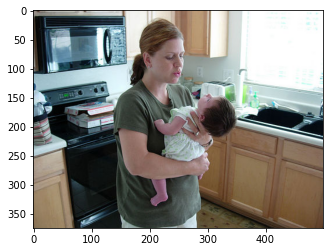

In [20]:
plt.imshow(img)

In [21]:
np.amin(img),np.amax(img)

(0, 255)

In [22]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

(1, 299, 299, 3)
-1.0 1.0


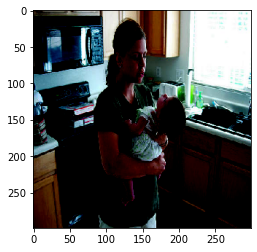

In [23]:
preprocessed_img = preprocess(path)
print (preprocessed_img.shape)
print (np.amin(preprocessed_img), np.amax(preprocessed_img))
plt.imshow(preprocessed_img[0,:,:,:])

## Attaining Attribute vector using Inception

In [24]:
inception = InceptionV3(weights='imagenet')
model = Model(inception.input, inception.layers[-2].output)

def findAttributeVector(image):
    img_path = os.path.join(img_dir, image) 
    image = preprocess(img_path) # preprocess the image
    vec = model.predict(image) # Get the encoding vector for the image
    vec = np.reshape(vec, vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return vec


96116736/96112376 [==============================] - 1s 0us/step


In [25]:
encoding_train = {}

for img in tqdm(train_images):
    encoding_train[img] = findAttributeVector(img)

100%|██████████| 20340/20340 [21:23<00:00, 15.85it/s]


In [26]:
import pickle
with open('train_img_id_comments.pkl','wb') as f:
    pickle.dump(train,f)

In [27]:
with open('train_img_encoding.pkl','wb') as f:
    pickle.dump(encoding_train, f)

## Building vocabulary

For train set, I will select all the unique words and add it to the vocabulary. There will be another two extra tokens a) out of vocabulary token (<unk>) and pad token(<pad>).

In [28]:
'''vocab = {}
for id in train.keys():
    comments = train[id]
    for comment in comments:
        words = comment.split(' ')
        for word in words:
            vocab[word] = vocab.get(word, 0) + 1
                
print ("Number of unique words in train corpus = %d" %(len(vocab.keys())))'''

'vocab = {}\nfor id in train.keys():\n    comments = train[id]\n    for comment in comments:\n        words = comment.split(\' \')\n        for word in words:\n            vocab[word] = vocab.get(word, 0) + 1\n                \nprint ("Number of unique words in train corpus = %d" %(len(vocab.keys())))'

Since the vocabulary dimension is pretty high, I am going to consider only those words which has atleast more than 30 occurence over the train corpus.

In [29]:
# words = [word for word in vocab.keys() if vocab[word]>30]
# len(words)

In [30]:
# vocab_words = set(words)
# vocab_words.add('<unk>') #token for out vocabulary word
# vocab_words.add('<pad>') #token for padding word
# vocab_words.add('<s>')   #token for start sequence
# vocab_words.add('</s>')  #token for end sequence
# print (len(vocab_words)) 

Finding maximum caption length. The comment will be converted to a matrix of size V*max_length where V is the size of the vocabulary.

In [31]:
# max_len = 0
# comment_lengths = []

# for img_id in tqdm(train.keys()):
#     for comment in train[img_id]:
#         l = len(comment.split(' '))
#         if l>max_len:
#             max_len = l
#         comment_lengths.append(l)
        


In [32]:
# max_len

In [33]:
# import seaborn as sns
# sns.distplot(comment_lengths)

From the distribution of comment lengths it seems that even though max comment length is 64 we can choose a lower value. We set a maximum comment length value of 30 and do not consider those instances which have a comment length higher than 30.

In [34]:
# threshold = 30
# print ("{} out of {} comments have length greater than {}".format(sum([c>threshold for c in comment_lengths]), len(comment_lengths), threshold))

In [35]:
# word2id = {}
# id2word = {}
# for i, word in enumerate(vocab_words):
#     word2id[word] = i
#     id2word[i] = word

In [36]:
# def sent2vec(comment, word2id, vocab, max_len = 30, start_token = '<s>', end_token = '</s>'): 
#     words = comment.split(' ')
    
#     #inserting start and end token
#     words.insert(0, start_token)
    
#     words.append(end_token)
    
    
#     vec = [0] * max_len
    
#     c = 0
#     for word in words:
#         if word in vocab:
#             vec[c] = word2id[word]
            
#         else:
#             vec[c] = word2id['<unk>']
        
#         c+=1
        
#     while c<max_len:
#         vec[c] = word2id['<pad>']
#         c+=1
        
#     return vec
        
    

In [37]:
# comment = train['17516940.jpg'][3]
# print (comment)
# print (sent2vec(comment, word2id, vocab_words, max_len = 30, start_token = '<s>', end_token = '</s>'))